## 1. Import necessary library ##

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import chemparse as cp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier

## 2. Preprocessing ##

* Import data

In [28]:
raw_data = pd.read_csv('data/lithium-ion batteries.csv')

In [29]:
raw_data.head()

,Materials Id,Formula,Spacegroup,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System
0,mp-849394,Li2MnSiO4,Pc,-2.699,0.006,3.462,16,2.993,178.513,True,monoclinic
1,mp-783909,Li2MnSiO4,P21/c,-2.696,0.008,2.879,32,2.926,365.272,True,monoclinic
2,mp-761311,Li4MnSi2O7,Cc,-2.775,0.012,3.653,28,2.761,301.775,True,monoclinic
3,mp-761598,Li4Mn2Si3O10,C2/c,-2.783,0.013,3.015,38,2.908,436.183,True,monoclinic
4,mp-767709,Li2Mn3Si3O10,C2/c,-2.747,0.016,2.578,36,3.334,421.286,True,monoclinic


* Strip and one-hot encode

In [65]:
data = raw_data.drop(["Materials Id","Spacegroup"], axis=1)

In [66]:
chrystal_sys_list = data["Crystal System"].unique()
for idx,sys in enumerate(chrystal_sys_list):
    print("Encode {} as {}".format(sys,idx))
    data["Crystal System"].replace(sys,idx,inplace=True)
data.head()

Encode monoclinic as 0
Encode orthorhombic as 1
Encode triclinic as 2


,Formula,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System
0,Li2MnSiO4,-2.699,0.006,3.462,16,2.993,178.513,True,0
1,Li2MnSiO4,-2.696,0.008,2.879,32,2.926,365.272,True,0
2,Li4MnSi2O7,-2.775,0.012,3.653,28,2.761,301.775,True,0
3,Li4Mn2Si3O10,-2.783,0.013,3.015,38,2.908,436.183,True,0
4,Li2Mn3Si3O10,-2.747,0.016,2.578,36,3.334,421.286,True,0


In [67]:
nn = data["Formula"].apply(cp.parse_formula)
nn = pd.json_normalize(nn)
nn = nn.fillna(0)
nn.head()

,Li,Mn,Si,O,Fe,Co
0,2.0,1.0,1.0,4.0,0.0,0.0
1,2.0,1.0,1.0,4.0,0.0,0.0
2,4.0,1.0,2.0,7.0,0.0,0.0
3,4.0,2.0,3.0,10.0,0.0,0.0
4,2.0,3.0,3.0,10.0,0.0,0.0


In [68]:
data=data.join(nn)
data.head()

,Formula,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Crystal System,Li,Mn,Si,O,Fe,Co
0,Li2MnSiO4,-2.699,0.006,3.462,16,2.993,178.513,True,0,2.0,1.0,1.0,4.0,0.0,0.0
1,Li2MnSiO4,-2.696,0.008,2.879,32,2.926,365.272,True,0,2.0,1.0,1.0,4.0,0.0,0.0
2,Li4MnSi2O7,-2.775,0.012,3.653,28,2.761,301.775,True,0,4.0,1.0,2.0,7.0,0.0,0.0
3,Li4Mn2Si3O10,-2.783,0.013,3.015,38,2.908,436.183,True,0,4.0,2.0,3.0,10.0,0.0,0.0
4,Li2Mn3Si3O10,-2.747,0.016,2.578,36,3.334,421.286,True,0,2.0,3.0,3.0,10.0,0.0,0.0


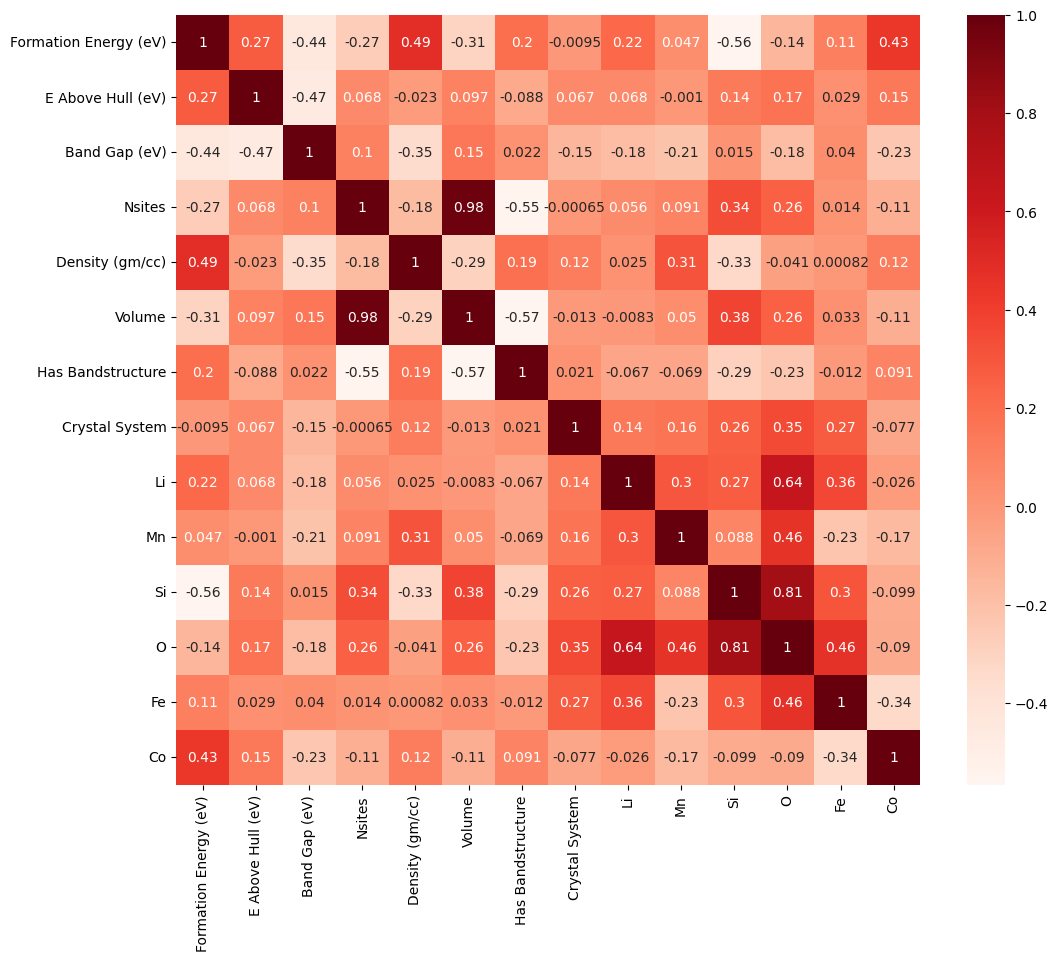

In [113]:
correlations = data.loc[:, ~data.columns.isin(['Formula'])].corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlations, annot=True,cmap=plt.cm.Reds)
plt.show()

## 3. Gradient Boost ##

In [71]:
chem_formula = data['Formula']
chem_formula

0            Li2MnSiO4
1            Li2MnSiO4
2           Li4MnSi2O7
3         Li4Mn2Si3O10
4         Li2Mn3Si3O10
            ...       
334       Li6Co(SiO4)2
335       LiCo3(SiO4)2
336    Li5Co4(Si3O10)2
337           LiCoSiO4
338      Li3Co2(SiO4)2
Name: Formula, Length: 339, dtype: object

In [72]:
X = data.drop(["Crystal System","Formula"], axis=1)
X

,Formation Energy (eV),E Above Hull (eV),Band Gap (eV),Nsites,Density (gm/cc),Volume,Has Bandstructure,Li,Mn,Si,O,Fe,Co
0,-2.699,0.006,3.462,16,2.993,178.513,True,2.0,1.0,1.0,4.0,0.0,0.0
1,-2.696,0.008,2.879,32,2.926,365.272,True,2.0,1.0,1.0,4.0,0.0,0.0
2,-2.775,0.012,3.653,28,2.761,301.775,True,4.0,1.0,2.0,7.0,0.0,0.0
3,-2.783,0.013,3.015,38,2.908,436.183,True,4.0,2.0,3.0,10.0,0.0,0.0
4,-2.747,0.016,2.578,36,3.334,421.286,True,2.0,3.0,3.0,10.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,-2.545,0.071,2.685,17,2.753,171.772,True,6.0,0.0,2.0,8.0,0.0,1.0
335,-2.250,0.076,0.005,42,3.318,552.402,True,1.0,0.0,2.0,8.0,0.0,3.0
336,-2.529,0.082,0.176,35,2.940,428.648,True,5.0,0.0,6.0,20.0,0.0,4.0
337,-2.348,0.087,1.333,14,2.451,214.044,True,1.0,0.0,1.0,4.0,0.0,1.0


In [73]:
y = data['Crystal System']
y

0      0
1      0
2      0
3      0
4      0
      ..
334    2
335    2
336    2
337    2
338    2
Name: Crystal System, Length: 339, dtype: int64

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=12)

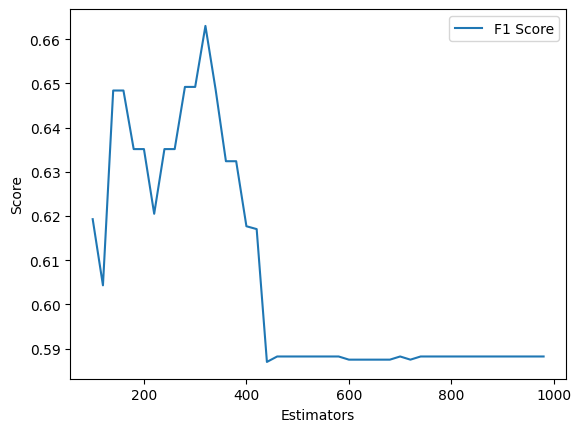

Performance max at: 320 with value of 0.6630237577895861


In [132]:
performance = pd.DataFrame([],columns=["F1 score", "Precision score", "Recall score"])
max = 1000
step = 20
start = 100
for weak_learners in range(start,max,step):
    model = GradientBoostingClassifier(n_estimators=weak_learners,learning_rate=0.11,max_depth=3,random_state=12)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f_score   =        f1_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
    recall    =    recall_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
    new_performance = [f_score.copy(),precision.copy(),recall.copy()]
    performance.loc[len(performance)] = new_performance
    # print("Precision: {}\nRecall: {}\nF1 Score: {}".format(precision,recall,f_score))


plt.plot(range(start,max,step), performance['F1 score'], label = "F1 Score")
# plt.plot(range(100,3000,20), performance['Precision score'], label = "Precision Score")
# plt.plot(range(100,3000,20), performance['Recall score'], label = "Recall Score")
plt.legend()
plt.xlabel("Estimators")
plt.ylabel("Score")
plt.show()

print("Performance max at: {} with value of {}".format(performance['F1 score'].idxmax()*step + start,performance['F1 score'].max()))


Learning rate is 320

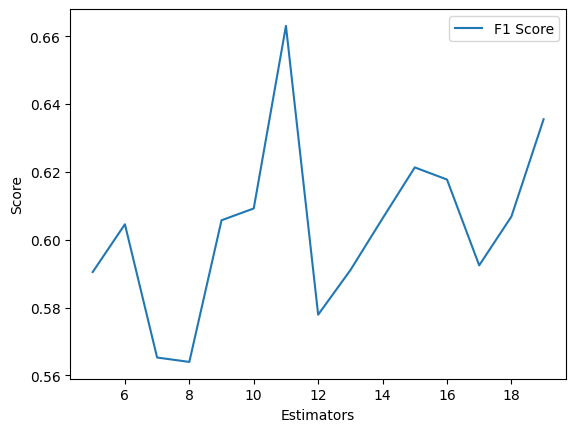

Performance max at: 0.11 with value of 0.6630237577895861


In [133]:
performance = pd.DataFrame([],columns=["F1 score", "Precision score", "Recall score"])
max = 20
step = 1
start = 5
for rate in range(start,max,step):
    model = GradientBoostingClassifier(n_estimators=320,learning_rate=rate*0.01,random_state=12)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f_score   =        f1_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
    recall    =    recall_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
    new_performance = [f_score.copy(),precision.copy(),recall.copy()]
    performance.loc[len(performance)] = new_performance
    # print("Precision: {}\nRecall: {}\nF1 Score: {}".format(precision,recall,f_score))


plt.plot(range(start,max,step), performance['F1 score'], label = "F1 Score")
# plt.plot(range(100,3000,20), performance['Precision score'], label = "Precision Score")
# plt.plot(range(100,3000,20), performance['Recall score'], label = "Recall Score")
plt.legend()
plt.xlabel("Estimators")
plt.ylabel("Score")
plt.show()

print("Performance max at: {} with value of {}".format((performance['F1 score'].idxmax()*step + start)*0.01,performance['F1 score'].max()))


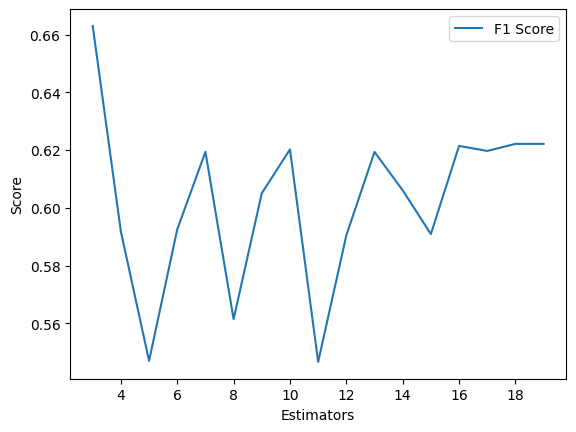

Performance max at depth 3 with value of 0.6630237577895861


In [134]:
performance = pd.DataFrame([],columns=["F1 score", "Precision score", "Recall score"])
max = 20
step = 1
start = 3
for depth in range(start,max,step):
    model = GradientBoostingClassifier(n_estimators=320,learning_rate=0.11,max_depth=depth,random_state=12)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f_score   =        f1_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
    precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
    recall    =    recall_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
    new_performance = [f_score.copy(),precision.copy(),recall.copy()]
    performance.loc[len(performance)] = new_performance
    # print("Precision: {}\nRecall: {}\nF1 Score: {}".format(precision,recall,f_score))


plt.plot(range(start,max,step), performance['F1 score'], label = "F1 Score")
# plt.plot(range(100,3000,20), performance['Precision score'], label = "Precision Score")
# plt.plot(range(100,3000,20), performance['Recall score'], label = "Recall Score")
plt.legend()
plt.xlabel("Estimators")
plt.ylabel("Score")
plt.show()

print("Performance max at depth {} with value of {}".format(performance['F1 score'].idxmax()*step + start,performance['F1 score'].max()))


In [136]:
performance = pd.DataFrame([],columns=["F1 score", "Precision score", "Recall score"])
model = GradientBoostingClassifier(n_estimators=320,learning_rate=0.11,max_depth=3,random_state=12)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f_score   =        f1_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
precision = precision_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
recall    =    recall_score(y_true=y_test, y_pred=y_pred, average='macro',zero_division=0)
performance.loc[len(performance)] = [f_score.copy(),precision.copy(),recall.copy()]
print("Precision: {}\nRecall: {}\nF1 Score: {}".format(precision,recall,f_score))


Precision: 0.6666666666666666
Recall: 0.6627140974967062
F1 Score: 0.6630237577895861


In [137]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
features_names = X.columns.to_numpy()
feature_importance_name = np.array(features_names)[sorted_idx]
for idx, item in enumerate(feature_importance_name):
    print("{}: {}".format(item,feature_importance[sorted_idx[idx]]))

Mn: 0.006059081116395456
Co: 0.012135143826134624
Has Bandstructure: 0.0162502724041981
Fe: 0.01739466796192707
Si: 0.018973890158704626
Li: 0.036441188547977864
E Above Hull (eV): 0.05865825706710076
Nsites: 0.08249437926546672
Formation Energy (eV): 0.08539260422375426
Density (gm/cc): 0.1074983172664828
Band Gap (eV): 0.11265884077767185
O: 0.1632569095762647
Volume: 0.28278644780792117


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


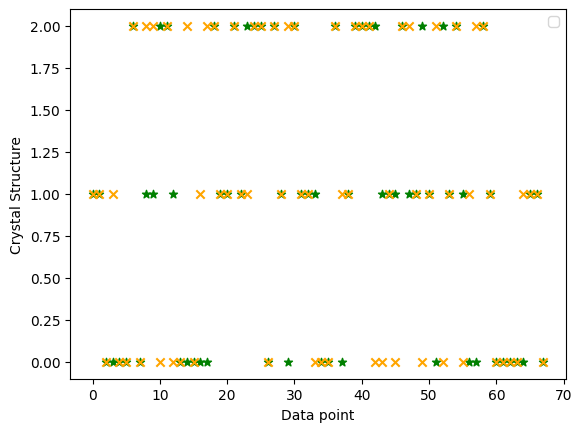

In [161]:
plt.scatter(x=range(0,len(y_pred)), y=y_pred, marker='*', c='green')
plt.scatter(x=range(0,len(y_test)), y=y_test, marker='x', c='orange')
plt.legend()
plt.xlabel("Data point")
plt.ylabel("Crystal Structure")
plt.show()

In [166]:
from sklearn.model_selection import cross_validate

# initiate a model
model = GradientBoostingClassifier(n_estimators=320,learning_rate=0.11,max_depth=3,random_state=12)

cv_results = cross_validate(model, X, y, cv = 5, scoring = "f1_macro", return_train_score = True)
print(list(cv_results.keys()))
print(cv_results["train_score"])
print(cv_results["test_score"])
print(np.average(cv_results["test_score"]))


['fit_time', 'score_time', 'test_score', 'train_score']
[1. 1. 1. 1. 1.]
[0.66581197 0.62689716 0.67903586 0.63148018 0.65130885]
0.6509068032330687
